# Анализ факторов успеваемости студентов


Используйте данные из файла **StudentPerformanceFactors.csv** с информацией о студентах.

[Источник](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors/code)

В нём содержаться следующие переменные:


| Название переменной | Описание переменной
|:-------------------:|:------------------:|
| Hours_Studied | Number of hours spent studying per week |
| Attendance | Percentage of classes attended |
| Parental_Involvement | Level of parental involvement in the student's education (Low, Medium, High)|
| Access_to_Resources | Availability of educational resources (Low, Medium, High)|
| Extracurricular_Activities | Participation in extracurricular activities (Yes, No).
| Sleep_Hours | Average number of hours of sleep per night.
| Previous_Scores |	Scores from previous exams.
| Motivation_Level |	Student's level of motivation (Low, Medium, High).
| Internet_Access |	Availability of internet access (Yes, No).
| Tutoring_Sessions |	Number of tutoring sessions attended per month.
| Family_Income |	Family income level (Low, Medium, High).
| Teacher_Quality |	Quality of the teachers (Low, Medium, High).
| School_Type |	Type of school attended (Public, Private).
| Peer_Influence |	Influence of peers on academic performance (Positive, Neutral, Negative).
| Physical_Activity |	Average number of hours of physical activity per week.
| Learning_Disabilities |	Presence of learning disabilities (Yes, No).
| Parental_Education_Level |	Highest education level of parents (High School, College, Postgraduate).
| Distance_from_Home |	Distance from home to school (Near, Moderate, Far).
| Gender |	Gender of the student (Male, Female).
| Exam_Score |	Final exam score.

Выполните, пожалуйста, задания.

In [1]:
!pip install pingouin

import pandas as pd
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import pointbiserialr, norm
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import warnings
warnings.filterwarnings("ignore")

Считываем датасет

In [3]:
df = pd.read_csv('StudentPerformanceFactors.csv')

Посчитаем количество NaN-ов

In [4]:
df.isna().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


### Используем в качестве зависимой переменной при построении линейной регрессии переменную Exam_Score. Выберем 3 категориальных и 3 метрических предиктора таким образом, что не наблюдается высокой корреляции между метрическими предикторами, а категориальные предикторы не дублируют друг друга по значениям.

In [5]:
num_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity"
]

df_corr = df[num_cols].corr(method='spearman')
df_corr

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity
Hours_Studied,1.000000,-0.009814,0.011187,0.024106,-0.012922,-0.002647
Attendance,-0.009814,1.000000,-0.012636,-0.020064,0.014771,-0.024181
Sleep_Hours,0.011187,-0.012636,1.000000,-0.022292,-0.006139,0.000871
Previous_Scores,0.024106,-0.020064,-0.022292,1.000000,-0.018188,-0.008226
Tutoring_Sessions,-0.012922,0.014771,-0.006139,-0.018188,1.000000,0.007509
Physical_Activity,-0.002647,-0.024181,0.000871,-0.008226,0.007509,1.000000


В качестве метрических переменных выбраны "Hours_Studied", "Attendance" и "Previous_Scores", т к корреляции между этими переменными не наблюдается. В качестве категориальных переменных выбраны "Family_Income", "Motivation_Level" и "School_Type", т к они далеки по смыслу друг от друга

In [6]:
df["Family_Income"].value_counts()

,count
Family_Income,
Low,2672
Medium,2666
High,1269


In [7]:
df["Motivation_Level"].value_counts()

,count
Motivation_Level,
Medium,3351
Low,1937
High,1319


In [8]:
df["School_Type"].value_counts()

,count
School_Type,
Public,4598
Private,2009


In [9]:
categorical_cols = ['Family_Income', 'Motivation_Level', 'School_Type']
df_dummies = pd.get_dummies(df, columns=categorical_cols, dtype=int)

df_dummies.head(20)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Internet_Access,Tutoring_Sessions,Teacher_Quality,...,Gender,Exam_Score,Family_Income_High,Family_Income_Low,Family_Income_Medium,Motivation_Level_High,Motivation_Level_Low,Motivation_Level_Medium,School_Type_Private,School_Type_Public
0,23,84,Low,High,No,7,73,Yes,0,Medium,...,Male,67,0,1,0,0,1,0,0,1
1,19,64,Low,Medium,No,8,59,Yes,2,Medium,...,Female,61,0,0,1,0,1,0,0,1
2,24,98,Medium,Medium,Yes,7,91,Yes,2,Medium,...,Male,74,0,0,1,0,0,1,0,1
3,29,89,Low,Medium,Yes,8,98,Yes,1,Medium,...,Male,71,0,0,1,0,0,1,0,1
4,19,92,Medium,Medium,Yes,6,65,Yes,3,High,...,Female,70,0,0,1,0,0,1,0,1
5,19,88,Medium,Medium,Yes,8,89,Yes,3,Medium,...,Male,71,0,0,1,0,0,1,0,1
6,29,84,Medium,Low,Yes,7,68,Yes,1,Medium,...,Male,67,0,1,0,0,1,0,1,0
7,25,78,Low,High,Yes,6,50,Yes,1,High,...,Male,66,1,0,0,0,0,1,0,1
8,17,94,Medium,High,No,6,80,Yes,0,Low,...,Male,69,0,0,1,1,0,0,1,0
9,23,98,Medium,Medium,Yes,8,71,Yes,0,High,...,Male,72,1,0,0,0,0,1,0,1


### Построем модель множественной линейной регрессии. Напишем уравнение регрессии. Оценим характеристики регрессионной модели в целом.

In [10]:
import statsmodels.api as sm

In [11]:
df_model2 = df_dummies.dropna(subset=[
    'Family_Income_High', 'Family_Income_Medium',
    'Motivation_Level_High', 'Motivation_Level_Low',
    'School_Type_Private', 'Hours_Studied', 'Attendance',
    'Previous_Scores', 'Exam_Score'
])

df_model2.shape

(6607, 25)

In [12]:
x_mult = df_model2[['Family_Income_High', 'Family_Income_Medium',
    'Motivation_Level_High', 'Motivation_Level_Low',
    'School_Type_Private', 'Hours_Studied', 'Attendance',
    'Previous_Scores']]
y = df_model2['Exam_Score']
x_mult_constant = sm.add_constant(x_mult)

In [13]:
model2 = sm.OLS(y, x_mult_constant).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     1194.
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:14:33   Log-Likelihood:                -15392.
No. Observations:                6607   AIC:                         3.080e+04
Df Residuals:                    6598   BIC:                         3.086e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    41.54

Отдельно построим модель со стандартизированными коэффициентами

In [14]:
from scipy.stats.mstats import zscore
model3 = sm.OLS(zscore(y), zscore(x_mult)).fit()
print(model3.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.592
Model:                            OLS   Adj. R-squared (uncentered):              0.591
Method:                 Least Squares   F-statistic:                              1195.
Date:                Fri, 30 Jan 2026   Prob (F-statistic):                        0.00
Time:                        10:14:33   Log-Likelihood:                         -6417.2
No. Observations:                6607   AIC:                                  1.285e+04
Df Residuals:                    6599   BIC:                                  1.290e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Оценим статистическую значимость регрессионных коэффициентов. Сравним их между собой по силе взаимосвязи с зависимой переменной. Подробно интерпретируем особенности взаимосвязи между каждым из предикторов и зависимой переменной. Определим, как именно каждый из предикторов взаимосвязан с зависимой переменной и какое изменение значений зависимой переменной можно ожидать при изменении значения предиктора на единицу.

In [15]:
print('R^2 = {:f}'.format(model2.rsquared))
print('F-test significance = {:f}'.format(model2.f_pvalue))

R^2 = 0.591531
F-test significance = 0.000000


Модель статистически значима. Объясняет 59,15% вариаций значений зависимой переменной.

Ниже посчитаем некоторые метрики для модели:

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

true_values = df_model2['Exam_Score']
predicted_values = model2.fittedvalues
mae = mean_absolute_error(true_values, predicted_values)
print('Mean Absolute Error:', mae)
mse = mean_squared_error(true_values, predicted_values)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error: 1.353431134880686
Mean Squared Error: 6.181513664935773
Root Mean Squared Error (RMSE): 2.486265002958408


In [17]:
print(f'Статистически значимые параметры модели: {model2.pvalues[model2.pvalues < 0.05].index.values}')

Статистически значимые параметры модели: ['const' 'Family_Income_High' 'Family_Income_Medium'
 'Motivation_Level_High' 'Motivation_Level_Low' 'Hours_Studied'
 'Attendance' 'Previous_Scores']


In [18]:
print(f'Статистически не значимые параметры модели: {model2.pvalues[model2.pvalues > 0.05].index.values}')

Статистически не значимые параметры модели: ['School_Type_Private']


Посмотрим на параметры модели:

In [19]:
l = []
for (param, index) in zip(model2.params[1:], model2.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))

print('Y = {:2f} + {}'.format(model2.params[0], ' + '.join(l)))

Y = 41.545927 + 1.09*Family_Income_High + 0.53*Family_Income_Medium + 0.51*Motivation_Level_High + -0.52*Motivation_Level_Low + 0.03*School_Type_Private + 0.29*Hours_Studied + 0.20*Attendance + 0.05*Previous_Scores


Модель регрессии показывает, каким образом каждый из предикторов связан с итоговым экзаменационным баллом. Константа модели равна 41.55 и интерпретируется как ожидаемый экзаменационный балл студента, который относится к референтным группам всех категориальных переменных (низкий семейный доход, средний уровень мотивации, государственная школа) и имеет нулевые значения по количественным переменным.

Переменная Family_Income_High имеет коэффициент 1.09, что означает: при прочих равных условиях студенты из семей с высоким уровнем дохода в среднем получают на 1.09 балла больше, чем студенты из семей с низким доходом, выступающих в роли референтной группы. Это влияние можно считать умеренным. Переменная Family_Income_Medium имеет коэффициент 0.53, то есть студенты со средним уровнем дохода показывают результаты примерно на 0.53 балла выше, чем представители низкого дохода.

Мотивация оказывает заметное влияние. Студенты с высокой мотивацией получают примерно на 0.51 балла больше, чем студенты со средней мотивацией (референтная категория). В то же время низкая мотивация снижает итоговый результат примерно на 0.52 балла. Таким образом, мотивация работает в обе стороны: высокая добавляет около полбалла студенту, а низкая столь же заметно уменьшает результат по сравнению со «средним» уровнем. Это влияние значимо.

Тип школы оказывает минимальное влияние. Коэффициент при переменной School_Type_Private равен всего 0.03, а сама переменная статистически незначима. Это означает, что при одинаковых условиях обучение в частной школе не даёт практически никаких преимуществ перед государственной, и различие в средних значениях настолько мало, что им можно пренебречь.

Среди количественных переменных наиболее сильное влияние оказывают показатели учебной активности. Каждый дополнительный час занятий в неделю увеличивает итоговый балл на 0.29 пункта, что делает Hours_Studied одним из наиболее значимых предикторов модели. Ещё более сильный эффект демонстрирует переменная Attendance: каждый дополнительный процент посещаемости повышает итоговый результат на 0.20 балла. Именно посещаемость является самым мощным предиктором среди всех включённых переменных.

Переменная Previous_Scores также положительно влияет на итоговый результат: каждый дополнительный балл в предыдущих экзаменах добавляет около 0.05 балла к текущему экзаменационному результату. Это слабое влияние, но оно статистически значимо.

В целом самые сильные влияния оказывают посещаемость и количество часов учёбы, то есть показатели текущей учебной вовлечённости. Уровень семейного дохода оказывает влияние средней силы, мотивация — слабой или средней силы, а предыдущие результаты — слабой силы. Тип школы почти не имеет значения.

### Проведём диагностику модели. Оценим распределение остатков. Рассмотрим наблюдается ли гетероскедастичность, рассмотрим сколько в модели выбросов и/или влияющих наблюдений

Остатки:

In [20]:
p = stats.kstest(model2.resid, 'norm', args=(model2.resid.mean(), model2.resid.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


<Axes: ylabel='Density'>

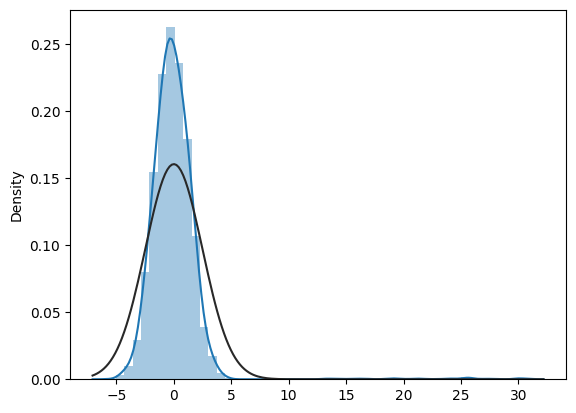

In [21]:
sns.distplot(model2.resid, fit=stats.norm)

Распределение остатков отличается от нормального распределения

Гетероскедастичость:

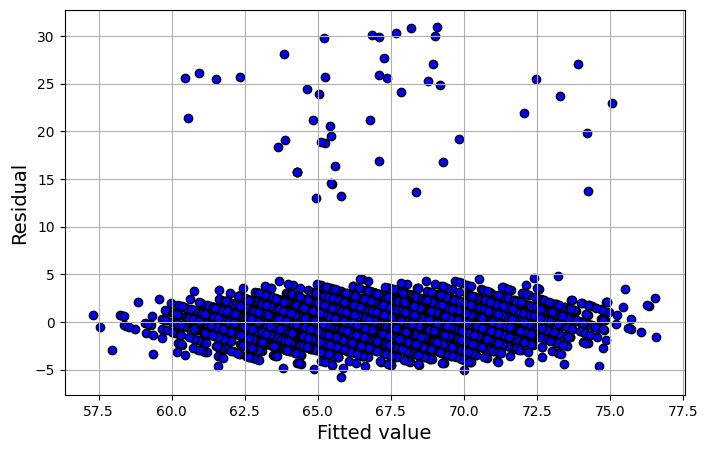

In [22]:
plt.figure(figsize=(8,5))
plt.scatter(x=model2.fittedvalues, y=model2.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

Не наблюдается взаимосвязь между остатками и предсказанными значениями зависимой переменной. Следовательно нет проблемы гетероскедастичности.

Дополнительно рассмотрим мультиколлинеарность:

In [23]:
vifs = np.array([vif(model2.model.exog, i) for i in range(model2.model.exog.shape[1])])

In [24]:
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model2.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
4,1.000919,School_Type_Private
6,1.001292,Attendance
5,1.001353,Hours_Studied
7,1.001930,Previous_Scores
3,1.115863,Motivation_Level_Low
2,1.117051,Motivation_Level_High
0,1.192315,Family_Income_High
1,1.192831,Family_Income_Medium


Нет значений VIF, превышающих 10. Проблема мультиколлинеарности отсутствует.

Выбросы и влияющие наблюдения:

In [25]:
influence = model2.get_influence()
inf_sum = influence.summary_frame()
inf_sum

,dfb_const,dfb_Family_Income_High,dfb_Family_Income_Medium,dfb_Motivation_Level_High,dfb_Motivation_Level_Low,dfb_School_Type_Private,dfb_Hours_Studied,dfb_Attendance,dfb_Previous_Scores,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.000623,4.055656e-03,0.004966,-0.000142,-0.006696,0.003189,-0.002374,-0.001574,0.000809,1.313752e-05,-0.368872,0.000868,-0.010874,-0.368847,-0.010873
1,-0.013137,2.675831e-04,-0.008932,0.000187,-0.012016,0.005344,0.001273,0.011092,0.009386,6.228845e-05,-0.655519,0.001303,-0.023677,-0.655490,-0.023676
2,-0.010077,1.350960e-04,0.006163,-0.004136,-0.004522,-0.003634,0.003414,0.008742,0.006125,2.654515e-05,0.441620,0.001223,0.015457,0.441593,0.015456
3,0.017217,-2.455897e-04,-0.010477,0.007160,0.007853,0.006093,-0.013576,-0.007952,-0.014831,9.055036e-05,-0.763824,0.001395,-0.028547,-0.763800,-0.028546
4,-0.000916,-4.716333e-05,0.005516,-0.003660,-0.004013,-0.003339,-0.000816,0.005109,-0.003276,1.459471e-05,0.397309,0.000831,0.011461,0.397284,0.011460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,0.001816,6.767349e-03,-0.000097,-0.002687,-0.003072,-0.002251,0.002983,-0.003394,0.000250,1.195472e-05,0.295043,0.001234,0.010373,0.295023,0.010372
6603,0.002450,-7.863359e-03,-0.009852,-0.006442,-0.007507,-0.005823,0.004210,-0.003075,0.003443,3.772566e-05,0.711771,0.000670,0.018426,0.711745,0.018426
6604,-0.000031,-6.353311e-04,-0.000766,0.000027,0.001048,-0.000509,0.000029,0.000602,-0.000504,3.657316e-07,0.057499,0.000995,0.001814,0.057494,0.001814
6605,-0.002741,-6.614436e-03,-0.008531,0.014351,-0.000358,0.011690,-0.012569,0.003845,0.008685,8.497077e-05,0.622656,0.001969,0.027654,0.622627,0.027653


In [26]:
inf_sum['dffits'][(inf_sum['dffits']>1) | (inf_sum['dffits']<-1)].sort_values()
# потенциальные влияющие наблюдения

,dffits


In [27]:
inf_sum['standard_resid'][(inf_sum['standard_resid']>3) | (inf_sum['standard_resid']<-3)].sort_values()
# потенциальные выбросы

,standard_resid
2542,5.246673
5125,5.316309
3924,5.478146
1607,5.534290
1099,5.830386
4254,5.855073
5989,6.314744
1863,6.315998
637,6.317090
2954,6.592463


### Общие выводы по результатам регрессионного анализа данных.

В результате регрессионного анализа удалось выявить ключевые факторы, которые наиболее существенно связаны с итоговым экзаменационным баллом студентов. Наибольший вклад в успех вносили показатели, отражающие учебную вовлечённость: посещаемость и количество часов, посвящённых изучению материала. Эти переменные продемонстрировали самое сильное влияние, что ожидаемо, т к они напрямую отражают интенсивность учебной деятельности.

Влияние оказывают и социально-демографические характеристики. Студенты из семей с более высоким уровнем дохода показывали несколько более высокие результаты экзамена, но сила этого эффекта оказалась умеренной и уступила влиянию учебных переменных. Мотивация также показала ожидаемую связь: высокая мотивация улучшает результаты, низкая — снижает их. Неожиданно было, что мотивация меньше влияет на итоговый балл студента, чем уровень дохода семьи.

Неожиданным оказался практически нулевой вклад типа школы: обучение в частной школе не даёт заметного преимущества перед государственной. Индивидуальные усилия студентов важнее формального типа образовательного учреждения.

В целом исследование подтвердило, что основные результаты экзамена объясняются прежде всего поведением и активностью самого студента, а внешние условия играют вторичную роль. Наиболее очевидным выводом стало доминирующее влияние посещаемости и учебного времени, тогда как более неожиданным результатом оказалось слабое влияние типа школы и относительно небольшой эффект мотивации.